In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [104]:
def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    if N==0: return lq0(x_,rho_,u_)
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    for n in range(N):
        print(x_[0,0])
        print(rho_[0,0])
        x_,rho_,u_,tlJ,_,_,_=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')
        lJ=lJ+tlJ
        print(tlJ[0])
        print(lJ[0])
        w[n,:]=lq0(x_,rho_,u_)-tlJ
        print(np.exp(w[n,0]))
        print(np.sum(np.exp(w[:n,0])))
        print()
    # end for
    return LogSumExp(w)-np.log(N),x_

def randqN(size,N,randq0,L,epsilon,grad_lp,xi=np.pi/16):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    x,rho,u=randq0(size)
    print(u.shape)
    for n in range(N):
        tx,trho,tu,_,_,_,_=flow(1,x[:,K>=n+1],rho[:,K>=n+1],u[K>=n+1],L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'fwd') # update those with large enough K
        x[:,K>=n+1]=tx
        rho[:,K>=n+1]=trho
        u[K>=n+1]=tu
    # end for
    return x,rho,u
    


def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps+1,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps+1,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps+1,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps):
        #print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=x,rho,u
    lJ=-lm(rho_)
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    lJ=lJ+lm(rho_)
    u_=(u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho))#(1-np.exp(-np.abs(rho))) #(M,d)->(M,d)
def lap_Qm(p)  : return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,u): return 0.5*np.sin(2*x+u)+0.5

In [152]:
# target specification
def lp(x): return gauss_lp(x,0,1)
def grad_lp(x): return -x

# ref specification
mu0=2
sigma0=0.3
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho)
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

ss=1000
q0_sample=mu0+sigma0*np.random.randn(1,ss)

In [153]:
size=1000
x=np.linspace(-4,4,size)[np.newaxis,:]
#x=np.random.randn(1,size)
rho=np.random.laplace(size=(1,size))
u=np.random.rand(size)
lq,newx=lqN(x,rho,u,N=100,lq0=lq0,L=50,epsilon=0.1,grad_lp=grad_lp,xi=np.pi/16)

-4.0
-0.4484321965019485
-0.009621765513435632
-0.009621765513435632
9.079280863867952e-07
0.0

1.0000000000000024
-7.958053962015373
7.604763948980221
7.595142183466785
6.51764994119748e-08
9.079280863867952e-07

0.8000000000000024
-0.533290013035139
0.3151533447758281
7.910295528242613
4.749960256653598e-09
9.7310458579877e-07

0.2000000000000026
0.44186333174070197
-0.49543374173149135
7.414861786511121
0.00019354969801602616
9.778545460554235e-07

0.8000000000000025
0.6372970734722055
-0.07604771341788297
7.338814073093238
0.09205123240974908
0.0001945275525620816

1.4000000000000028
0.05334478689010111
-1.4074160254772723
5.931398047615966
4.1214713884825344e-20
0.09224575996231116

-0.7999999999999975
-2.079239187632616
0.46315649062962727
6.394554538245593
0.21493729914145773
0.09224575996231116

1.8000000000000032
-0.4439173029969984
-0.16981421120418827
6.224740327041405
1.6334474206291098e-32
0.30718305910376886

-1.5999999999999979
-0.9537315142011746
-0.5621760430060898
5.6

(array([  2.,  12.,  47., 137., 222., 259., 182.,  91.,  42.,   6.]),
 array([-3.51731732, -2.85861862, -2.19991992, -1.54122122, -0.88252252,
        -0.22382382,  0.43487487,  1.09357357,  1.75227227,  2.41097097,
         3.06966967]),
 <BarContainer object of 10 artists>)

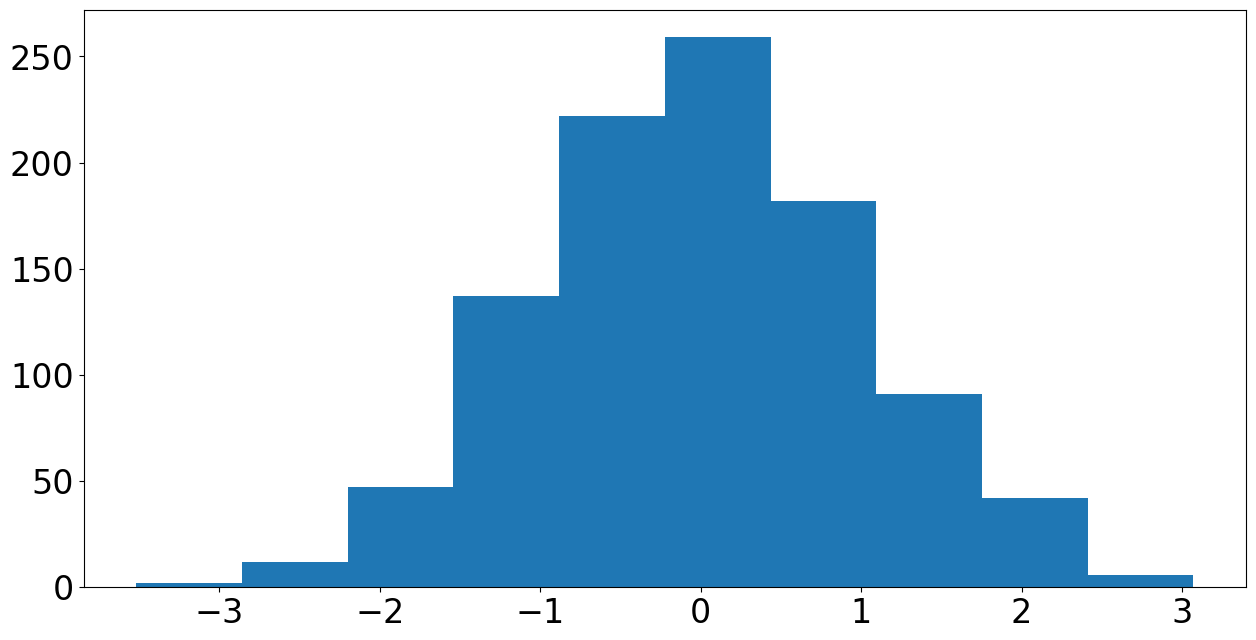

In [154]:
plt.hist(newx[0,:])

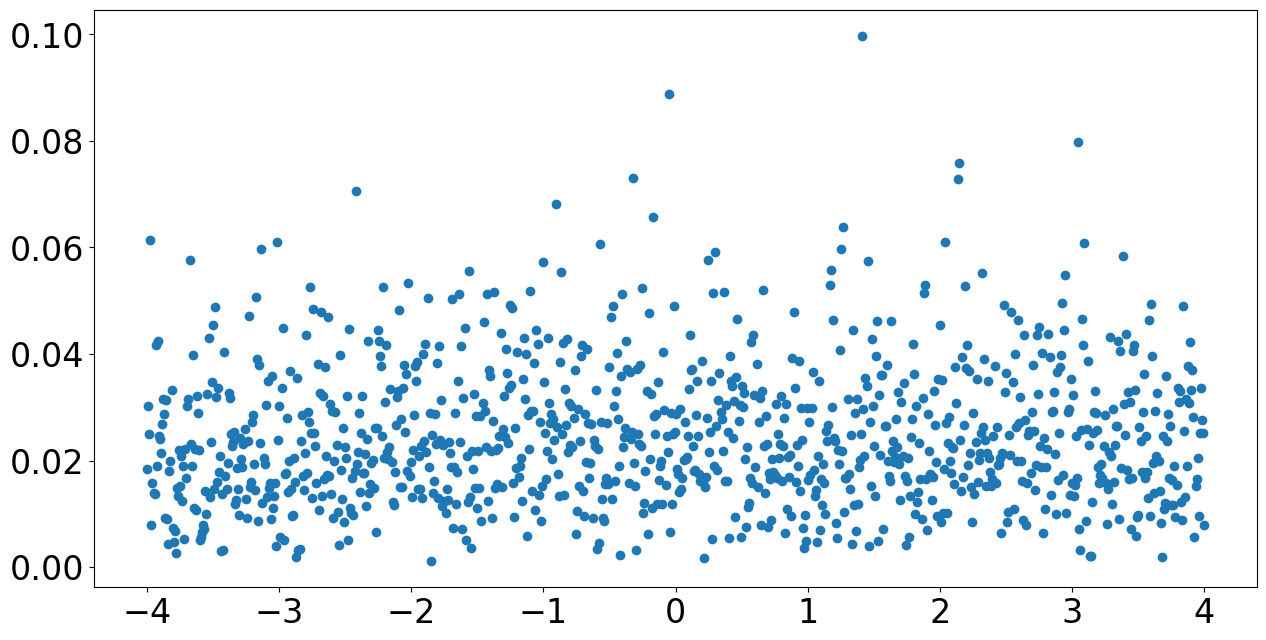

In [155]:
plt.scatter(x[0,:],np.exp(lq))

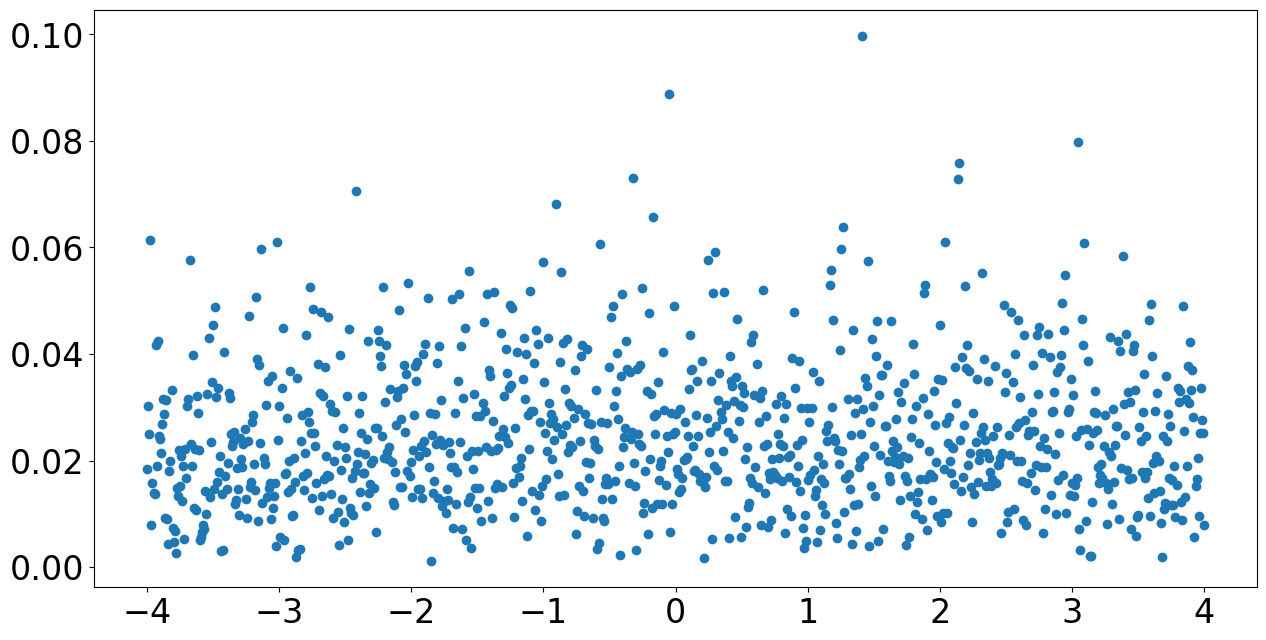

In [156]:
args=np.argsort(x[0,:])
plt.scatter(x[0,args],np.exp(lq[args]))

## Forward pass

In [157]:
# settings
steps=100
ss=10000
x=mu0+sigma0*np.random.rand(1,ss)
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16

In [158]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='fwd')

In [159]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

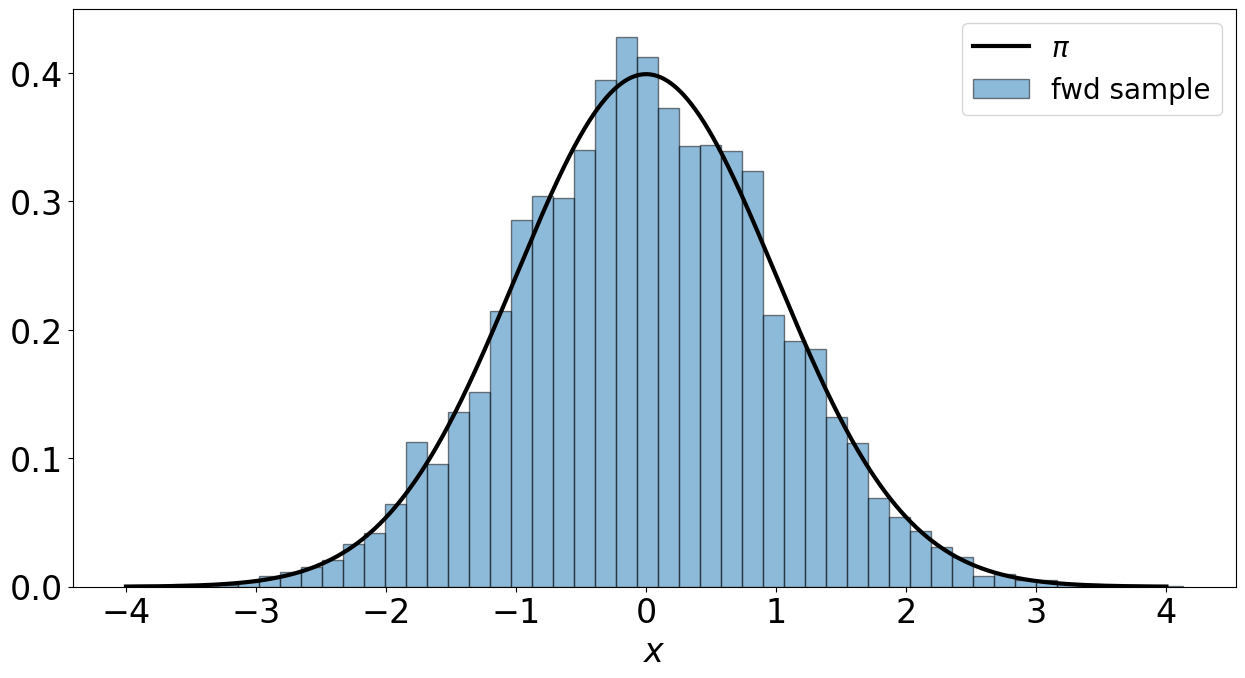

In [175]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small')

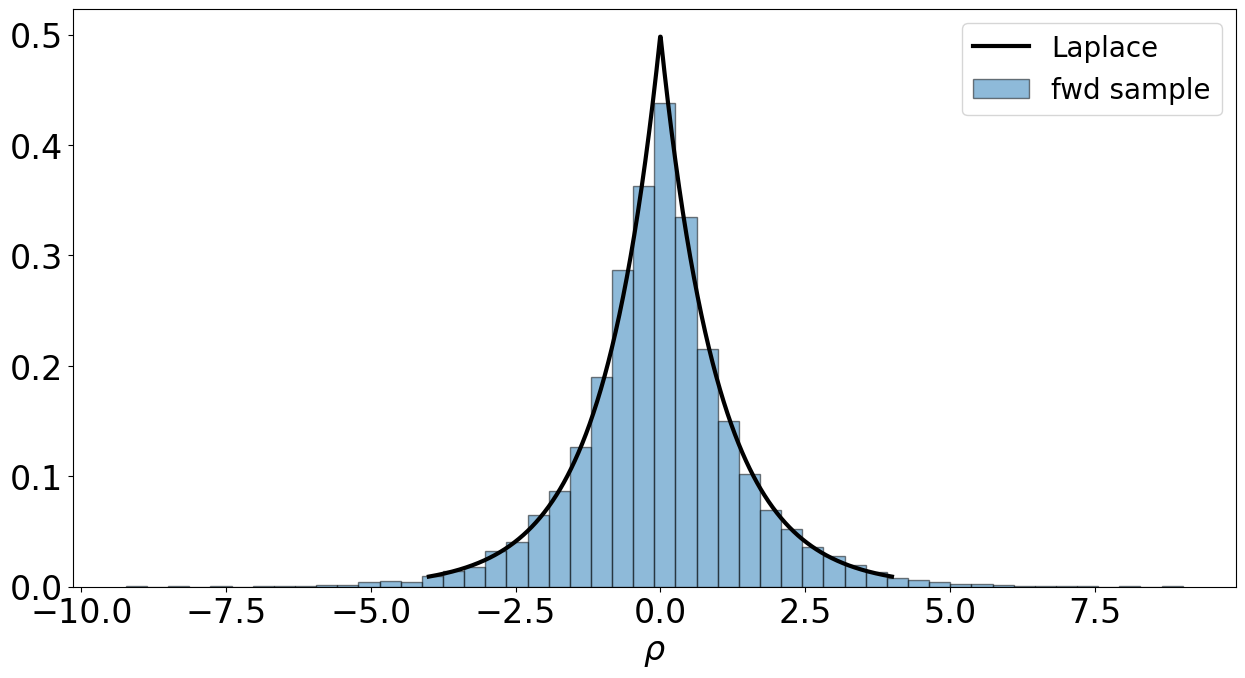

In [174]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small')

Text(0.5, 0, '$u$')

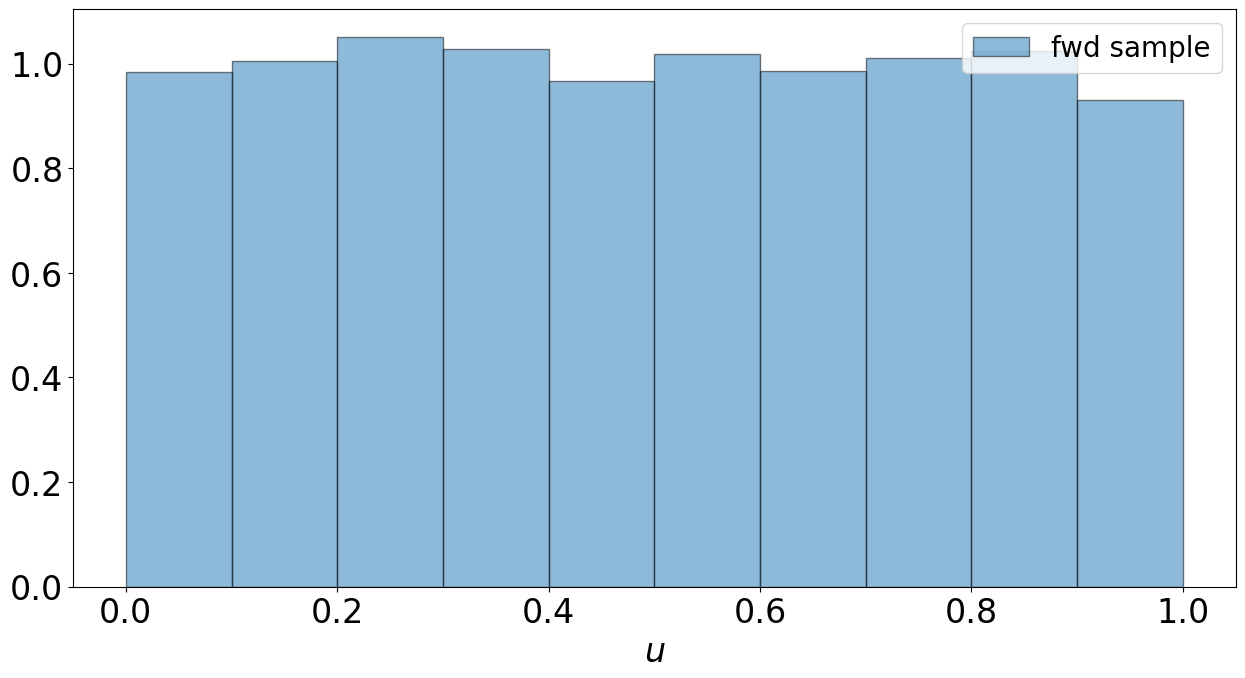

In [177]:
plt.hist(up,alpha=0.5,density=True,bins=10,ec='black',label='fwd sample');
plt.legend(fontsize='small')
plt.xlabel(r'$u$')

## Backward pass

In [149]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

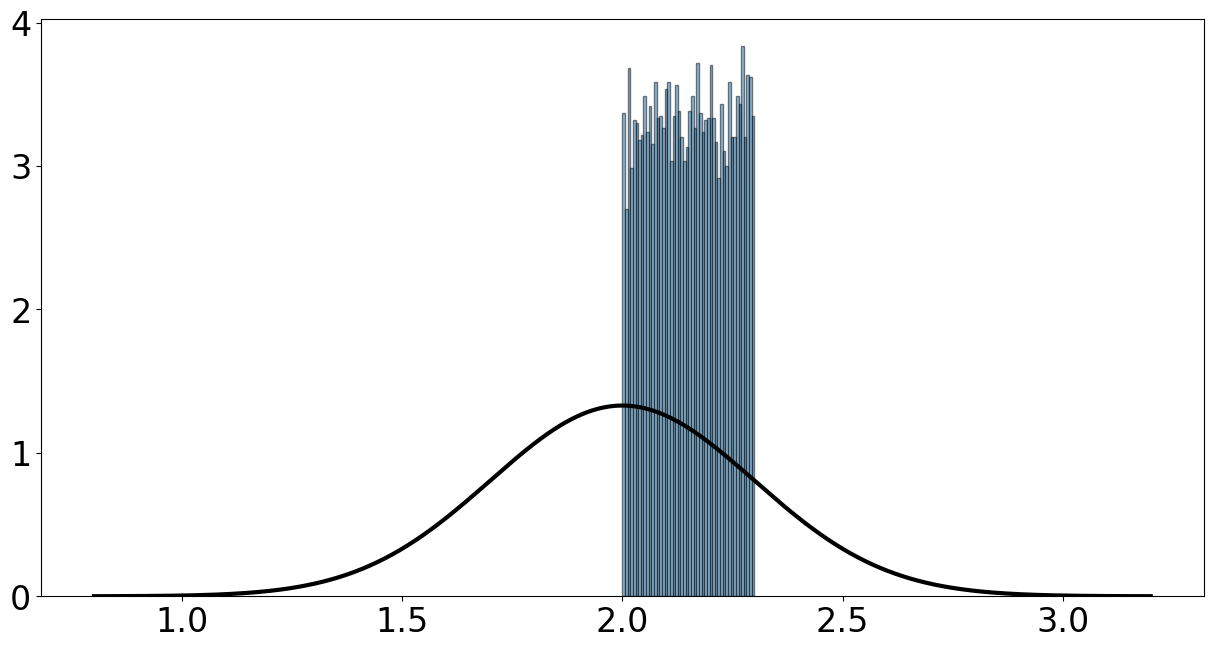

In [180]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');

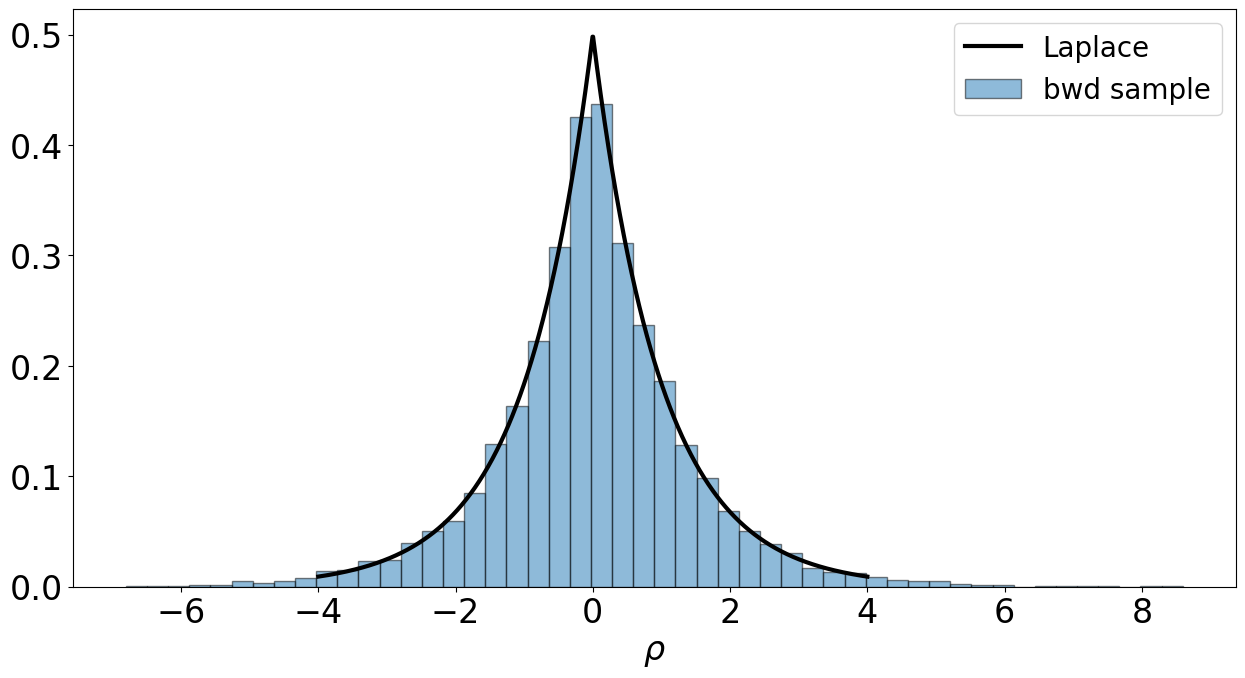

In [179]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small')

Text(0.5, 0, '$u$')

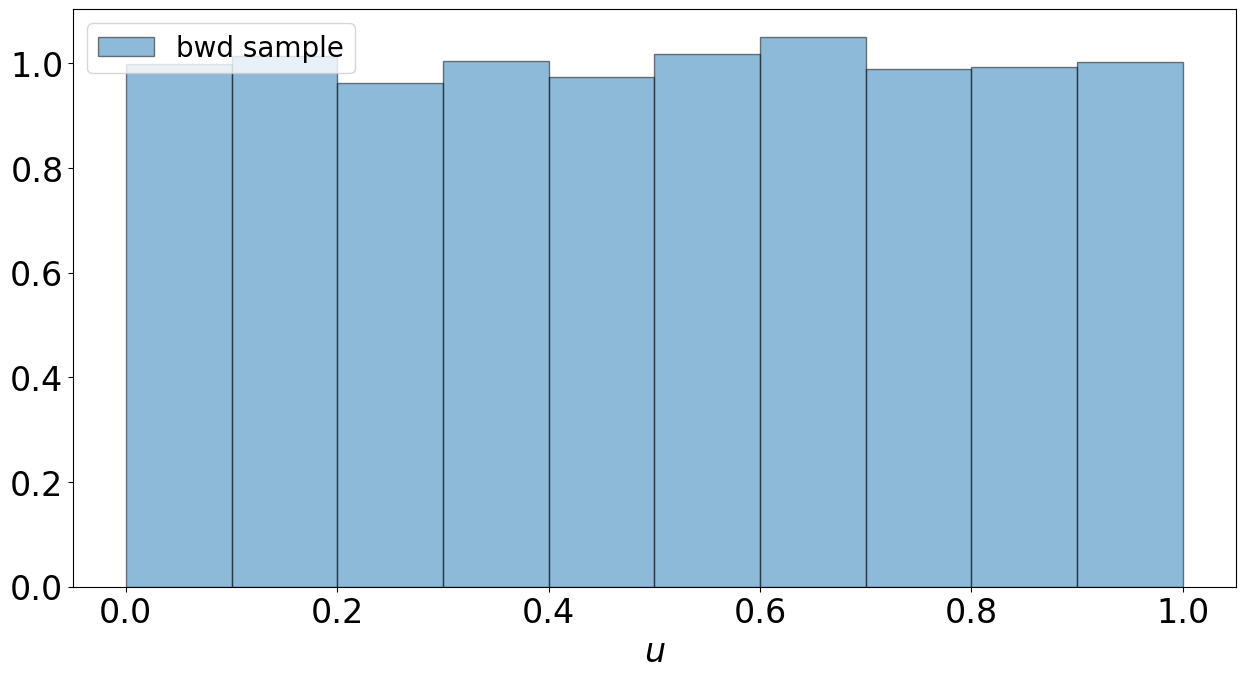

In [178]:
plt.hist(upp,alpha=0.5,density=True,bins=10,ec='black',label='bwd sample');
plt.legend(fontsize='small')
plt.xlabel(r'$u$')

## Stability

Here we show a traceplot of the inverse flow with the (reversed) forward flow
to see if inversion is correct.

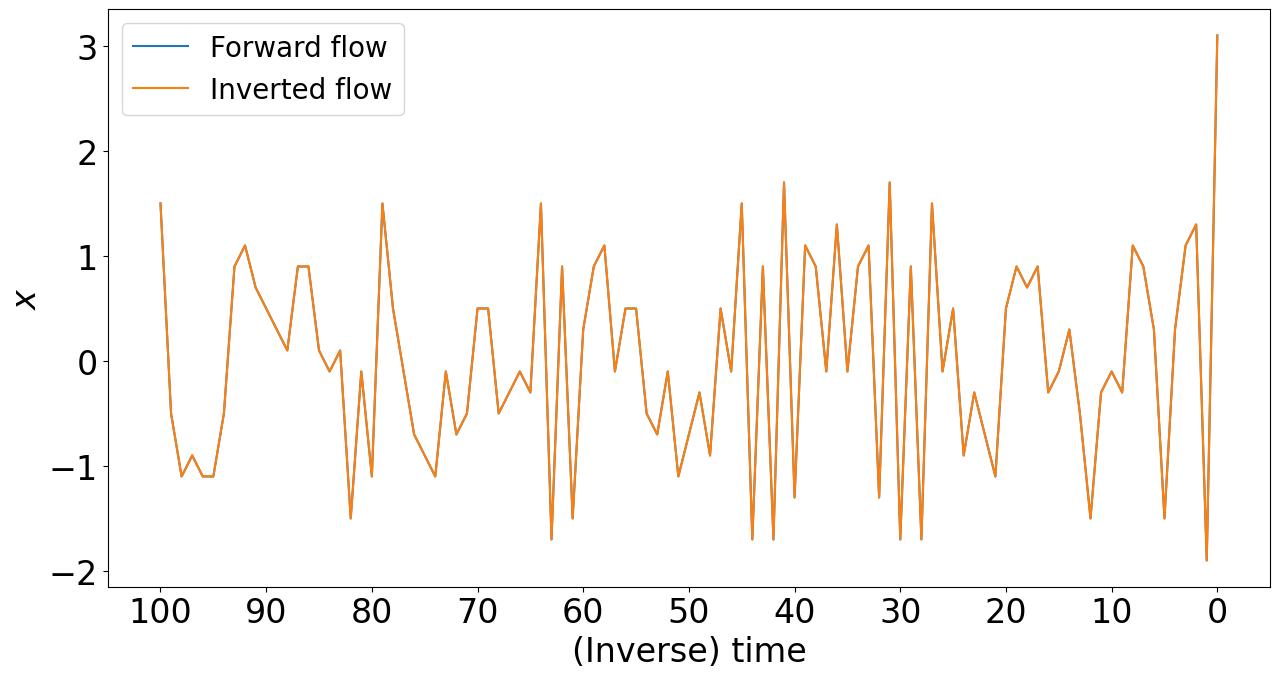

In [126]:
plt.plot(np.arange(0,steps+1),np.flip(xs[:,0,0]),label='Forward flow')
plt.plot(np.arange(0,steps+1),xps[:,0,0],label='Inverted flow')
plt.legend(fontsize='small')
plt.ylabel(r'$x$')
plt.xlabel('(Inverse) time')
plt.xticks(ticks=np.linspace(0,steps,11),
          labels=np.flip(np.linspace(0,steps,11,dtype=int)));

## Density

## Sampling

(10000,)


Text(0.5, 0, '$x$')

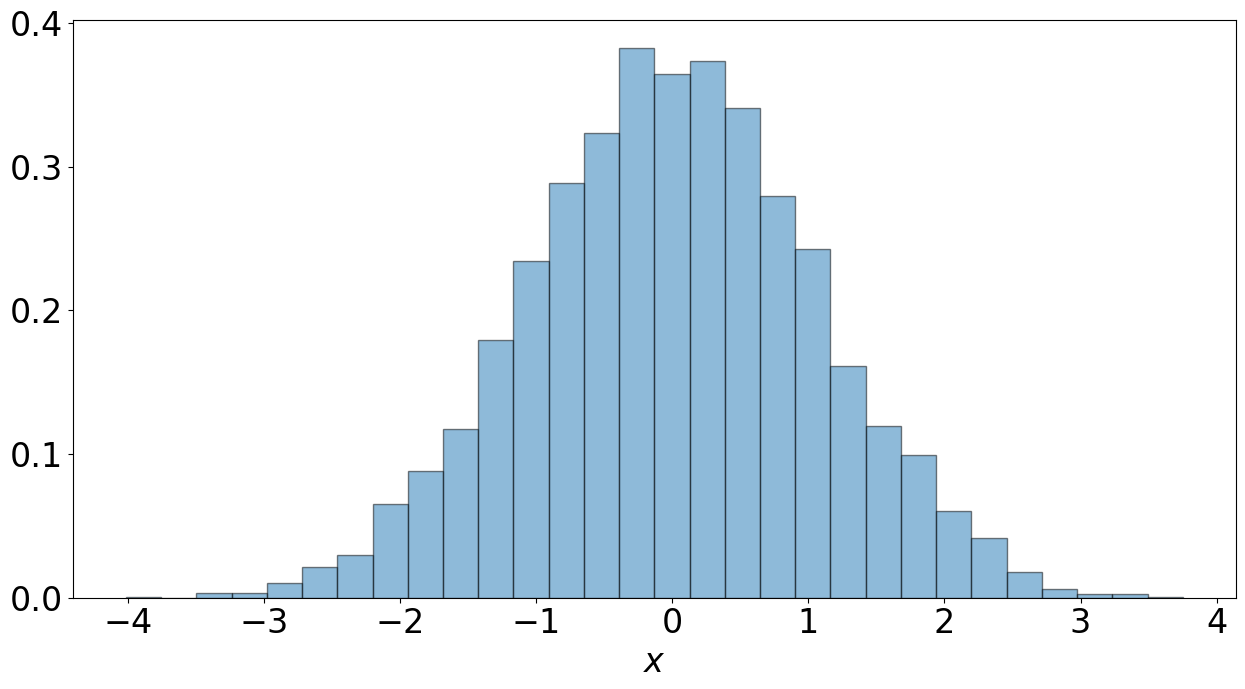

In [129]:
size=10000
steps=100
xx,rrho,uu=randqN(size,steps,randq0,L,epsilon,grad_lp,xi)
plt.hist(xx[0,:],bins=30,density=True,ec='black',alpha=0.5)
plt.xlabel(r'$x$')